In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytesseract

이미지 크기:  (466, 700, 3)


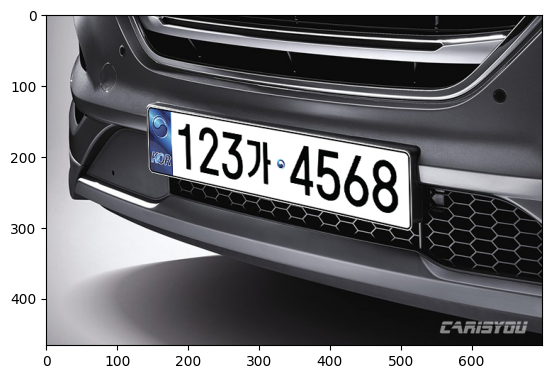

In [2]:
img = cv2.imread('./data/license_plate4.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print('이미지 크기: ',img.shape)

plt.imshow(img)
plt.show()

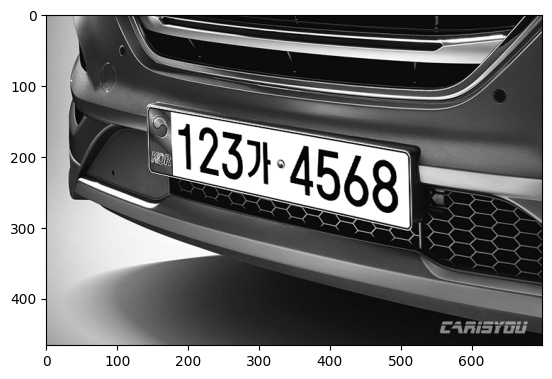

In [3]:
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

plt.imshow(img_gray, 'gray')
plt.show()

# Maximize Contrast

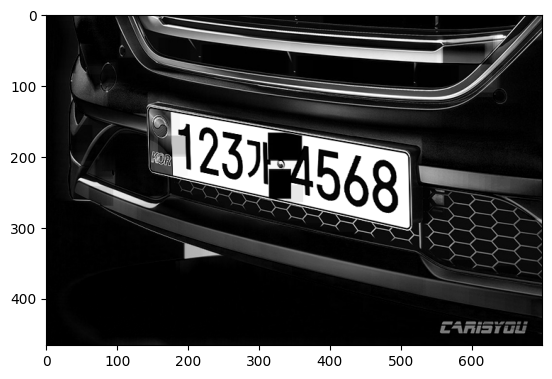

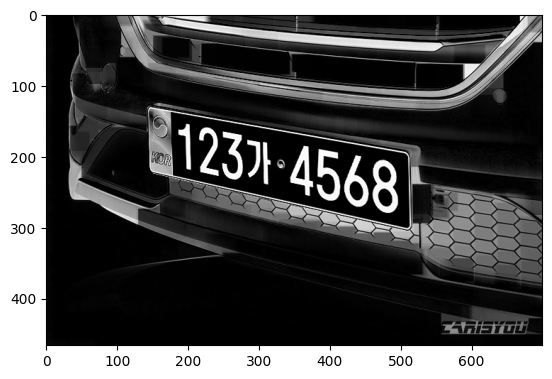

In [22]:
# 모폴로지 연산
structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT ,(24,24))
#print(structuringElement)

# TopHat --> 밝기 값이 크게 변하는 부분 강조
imgTopHat = cv2.morphologyEx(img_gray, cv2.MORPH_TOPHAT, structuringElement)
plt.imshow(imgTopHat, 'gray')
plt.show()

# BlackHat --> 어두운 부분 강조
imgBlackHat = cv2.morphologyEx(img_gray, cv2.MORPH_BLACKHAT, structuringElement)
plt.imshow(imgBlackHat, 'gray')
plt.show()

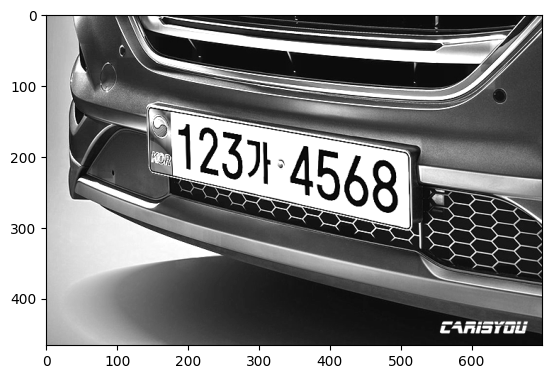

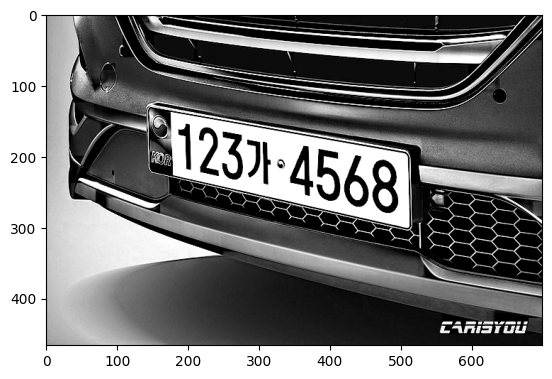

In [5]:
# 두 이미지 합치기 & 빼기
img_added = cv2.add(img_gray, imgTopHat)
plt.imshow(img_added, 'gray')
plt.show()

img_subtracted = cv2.subtract(img_added, imgBlackHat)
plt.imshow(img_subtracted, 'gray')
plt.show()

# 이미지 이진화

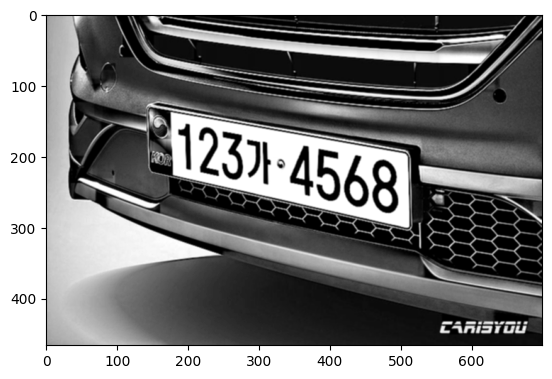

In [23]:
img_blurred = cv2.GaussianBlur(img_subtracted, ksize=(3,3), sigmaX=0)

plt.imshow(img_blurred, 'gray')
plt.show()

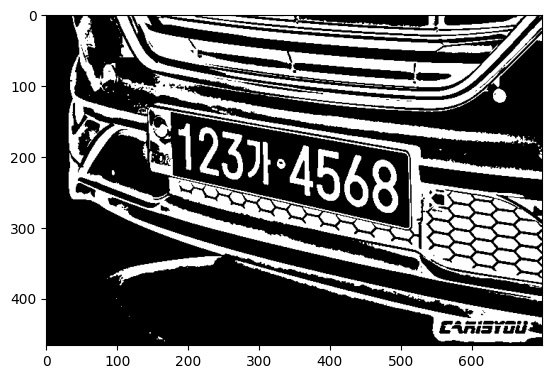

In [24]:
img_thresh = cv2.adaptiveThreshold(
    img_blurred,
    maxValue=255.0,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=51,   # 홀수여야함
    C=9
)

plt.imshow(img_thresh, 'gray')
plt.show()

# 이미지 외각 검출 (Find Contours)

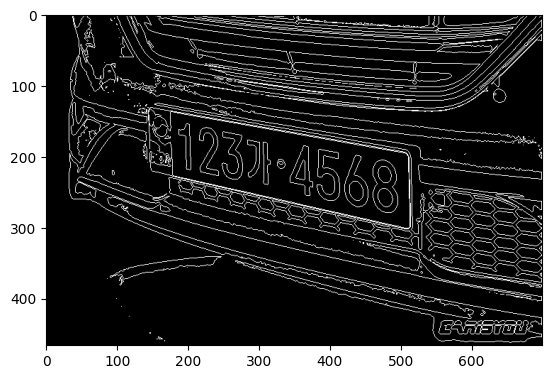

In [25]:
contours, heirachy = cv2.findContours(
    img_thresh,
    mode=cv2.RETR_LIST,
    method=cv2.CHAIN_APPROX_SIMPLE
)

height, width, channel = img.shape
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

# 외각선 그리기
cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255,255,255))
plt.imshow(temp_result,'gray')
plt.show()

# 바운딩 박스 표시

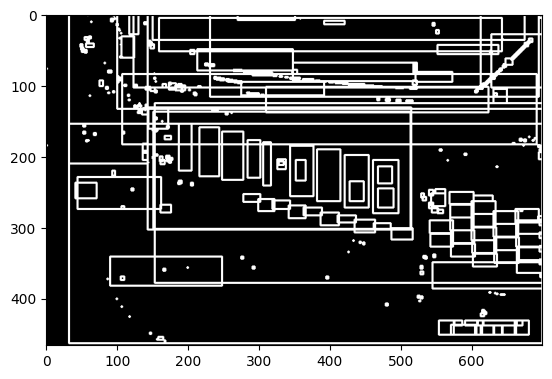

In [26]:
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x,y), pt2=(x+w,y+h), color=(255,255,255), thickness=2)
    
    # insert to dict
    contours_dict.append({
        'contour' : contour,
        'x' : x,
        'y' : y,
        'w' : w,
        'h' : h,
        'cx' : x + (w/2),
        'cy' : y + (h/2)
    })
    
plt.imshow(temp_result,'gray')
plt.show()

# Select Candidates by Char Size

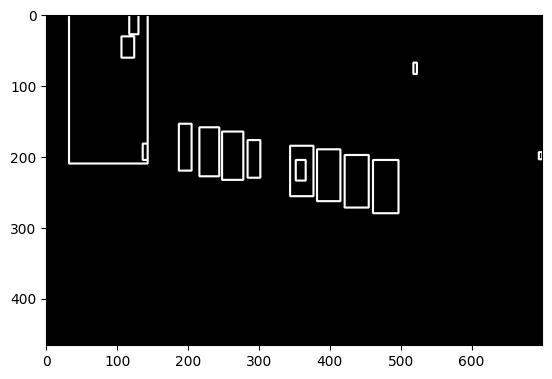

In [27]:
MIN_AREA = 40
MIN_WIDTH, MIN_HEIGHT = 2,8
MIN_RATIO, MAX_RATIO = 0.25, 0.61

possible_contours=[]

cnt=0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_WIDTH \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)
        
# 시각화
temp_result2 = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
    x1, y1, w1, h1 = d['x'], d['y'], d['w'], d['h']
    cv2.rectangle(temp_result2, pt1=(x1,y1) , pt2=(x1+w1, y1+h1), color=(255, 255, 255), thickness=2)
    
plt.imshow(temp_result2)
plt.show()

# Select Candidates by Arrangement of Contours

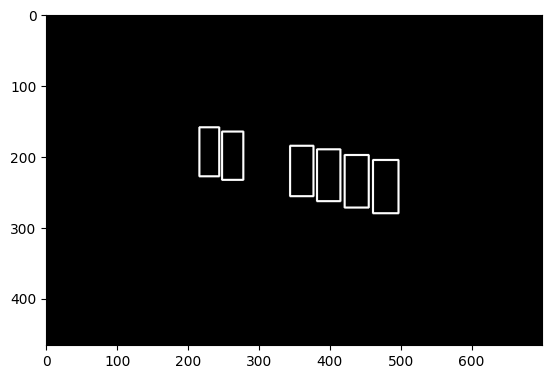

In [28]:
MAX_DIAG_MULTIPLIER = 10
MAX_ANGLE_DIFF = 12.0
MAX_AREA_DIFF = 0.5
MAX_WIDTH_DIFF = 0.8
MAX_HEIGHT_DIFF = 0.1
MIX_N_MATCHED = 3

def find_chars(contour_list):
    matched_result_idx = []
    
    for d1 in contour_list:
        matched_contours_idx = []
        
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue
                
            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])
            
            diagonal_length1 = np.sqrt(d1['w']**2 + d1['h']**2)
            
            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy/dx))
                
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']
            
            if distance < diagonal_length1 * MAX_DIAG_MULTIPLIER \
                    and angle_diff < MAX_ANGLE_DIFF \
                    and area_diff < MAX_AREA_DIFF \
                    and width_diff < MAX_WIDTH_DIFF \
                    and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])
        
        matched_contours_idx.append(d1['idx'])
        
        if len(matched_contours_idx) < MIX_N_MATCHED:
            continue
        
        matched_result_idx.append(matched_contours_idx)
        
        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])
        
        unmatched_contour = np.take(contour_list, unmatched_contour_idx)
        
        # Recursive call
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)
        
        break
    
    return matched_result_idx

result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))

# Visualization
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x'] + d['w'], d['y'] + d['h']),
                      color=(255, 255, 255), thickness=2)

plt.imshow(temp_result, 'gray')
plt.show()

# 차량 번호판 회전

In [12]:
PLATE_WIDTH_PADDING = 1.3  #번호판 주변 여유 공간 (양옆)
PLATE_HEIGHT_PADDING = 1.5  
MIN_PLATE_RATIO = 3    # 가로세로 비율의 최소값
MAX_PLATE_RATIO = 10

plate_imgs=[]
plate_infos=[]

for i, matched_chars in enumerate(matched_result):   #enumerate = idx, 해당요소 반환
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])
    print(sorted_chars)
    
    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) /2  # 가장 왼쪽 + 가장 오른쪽 좌표를 더하고 나눠 중앙값구함
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) /2
    
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING 
    # 가장 오른쪽 박스의 오른쪽 끝 + 가장 왼쪽 박스의 왼쪽끝 좌표를 빼서 총 너비 구함
    
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']
        
    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING) #모든 박스의 높이의 평균을 구해서 번호판의 높이 설정
    
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy'] 
    # 리스트의 가장 오른쪽, 왼쪽의 높이 중심값을 이용하여 삼각형 높이 계산
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )

[{'contour': array([[[226, 159]],

       [[225, 160]],

       [[222, 160]],

       [[218, 164]],

       [[218, 165]],

       [[217, 166]],

       [[217, 169]],

       [[216, 170]],

       [[216, 176]],

       [[217, 177]],

       [[220, 177]],

       [[221, 178]],

       [[222, 177]],

       [[222, 171]],

       [[223, 170]],

       [[223, 169]],

       [[225, 167]],

       [[230, 167]],

       [[235, 172]],

       [[235, 174]],

       [[236, 175]],

       [[236, 183]],

       [[235, 184]],

       [[235, 185]],

       [[234, 186]],

       [[234, 187]],

       [[232, 189]],

       [[232, 190]],

       [[231, 191]],

       [[231, 192]],

       [[229, 194]],

       [[229, 195]],

       [[228, 196]],

       [[228, 197]],

       [[226, 199]],

       [[226, 200]],

       [[225, 201]],

       [[225, 202]],

       [[224, 203]],

       [[224, 204]],

       [[222, 206]],

       [[222, 207]],

       [[221, 208]],

       [[221, 209]],

       [[219, 211]]

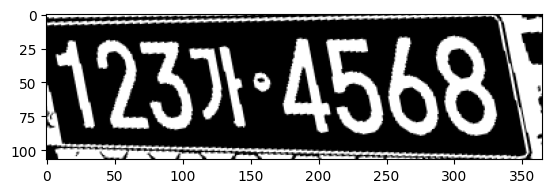

[{'x': 171, 'y': 164, 'w': 365, 'h': 107}, {'x': 171, 'y': 164, 'w': 365, 'h': 107}]
[array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,  85,   0,   0],
       ...,
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255]], dtype=uint8), array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,  85,   0,   0],
       ...,
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255]], dtype=uint8)]


In [29]:
angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))
rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0) # 이미지 회전을 위한 변환 행렬 생성
img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width,height))  # 생성 값 이용하여 변환

img_cropped = cv2.getRectSubPix(
    img_rotated,
    patchSize=(int(plate_width), int(plate_height)),
    center=(int(plate_cx), int(plate_cy))
)

plate_imgs.append(img_cropped)
plate_infos.append({
    'x': int(plate_cx - plate_width / 2),
    'y': int(plate_cy - plate_height / 2),
    'w': int(plate_width),
    'h': int(plate_height)
})

plt.imshow(img_cropped,'gray')
plt.show()
print(plate_infos)
print(plate_imgs)

# Another Threshold to Find Chars

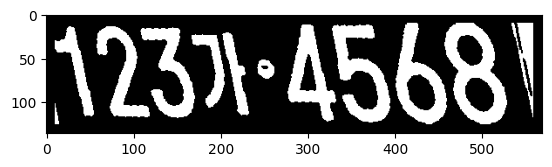

In [30]:
longest_idx, longest_text = -1, 0
plate_chars = []

for i, plate_img in enumerate(plate_imgs):
    plate_img = cv2.resize(plate_img, dsize=(0,0), fx=1.6, fy=1.6)
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    #plt.imshow(plate_img,'gray')
    #plt.show()

    # find contours again
    contours, hierachy = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)

    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0

    for contour in contours:
        x2, y2, w2, h2 = cv2.boundingRect(contour)

        area2 = w2 * h2
        ratio2 = w2 / h2

        if area2 > MIN_AREA and w2 > MIN_WIDTH and MIN_RATIO < ratio2 < MAX_RATIO:
            if x2 < plate_min_x:
                plate_min_x = x2
            if y2 < plate_min_y:
                plate_min_y = y2
            if x2 + w2 > plate_max_x:
                plate_max_x = x2 + w2
            if y2 + h2 > plate_max_y:
                plate_max_y = y2 + h2

    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]

    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10,
                                    borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))

plt.imshow(img_result, 'gray')
plt.show()

{'x': 171, 'y': 164, 'w': 365, 'h': 107}


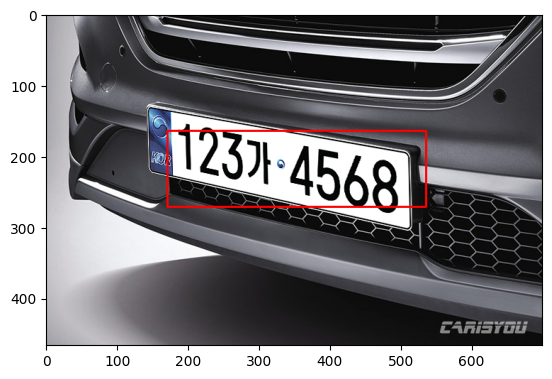

In [15]:
info = plate_infos[longest_idx]
print(info)
img_out = img.copy()

cv2.rectangle(img_out, pt1=(info['x'], info['y']), pt2=(info['x']+info['w'], info['y']+info['h']), color=(255,0,0), thickness=2)

plt.imshow(img_out)
plt.show()